In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import StandardScaler # Used for scaling of data
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import metrics
import seaborn as sns
import matplotlib.pyplot as plt
from keras import backend as K
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

Dettol

In [3]:
# Handling Outliers
#train_df.sort_values(by = 'GrLivArea', ascending = False)[:2]
#Deleting outliers
df_train = df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index)
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)
df_train = df_train.reset_index(drop=True)

# Combine train and test, separate SalePrice from rest of train
data_all = pd.concat([df_train,df_test],sort=False,ignore_index=True).drop(['SalePrice'], axis=1)

In [4]:
processed_df = data_all.copy()

for columnName in processed_df: # loop through columns
    columnSeriesObj = processed_df[columnName]

    if type(columnSeriesObj[0])==str or type(columnSeriesObj[0])==float: # find column with str or object
        # create replacement list
        uniq_value_of_col = []
        uniq_value_of_col = processed_df[columnName].unique()
        num_of_nums = len(uniq_value_of_col)
        replacement_list =  np.arange(num_of_nums)

        # replace elements of list
        processed_df[columnName]=processed_df[columnName].replace(uniq_value_of_col, replacement_list) # replace elements in column
    
processed_df.shape

(2917, 80)

In [5]:
# Remove 2 columns with too any NaNs
#processed_df=processed_df.drop(columns=['LotFrontage','PoolQC','MiscFeature','Alley','FireplaceQu','Fence','GarageYrBlt'])

# Check for NaNs 
# findNaN = processed_df[processed_df.isna().any(axis=1)]

# Drop pretty uncorrelated columns         
#processed_df=processed_df.drop(columns=['YrSold','LowQualFinSF','MiscVal','BsmtHalfBath','BsmtFinSF2','3SsnPorch','MoSold'])
processed_df=processed_df.drop(columns=['Id'])

# Fill in stupid nan rows with mean..
processed_df = processed_df.fillna(processed_df.dropna().median())

processed_df

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,0,65.0,8450,0,0,0,0,0,0,...,0,0,0,0,0,0,2,2008,0,0
1,20,0,80.0,9600,0,0,0,0,0,1,...,0,0,0,0,0,0,5,2007,0,0
2,60,0,68.0,11250,0,0,1,0,0,0,...,0,0,0,0,0,0,9,2008,0,0
3,70,0,60.0,9550,0,0,1,0,0,2,...,0,0,0,0,0,0,2,2006,0,1
4,60,0,84.0,14260,0,0,1,0,0,1,...,0,0,0,0,0,0,12,2008,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2912,160,1,21.0,1936,0,0,0,0,0,0,...,0,0,0,0,0,0,6,2006,0,0
2913,160,1,21.0,1894,0,0,0,0,0,0,...,0,0,0,0,0,0,4,2006,0,1
2914,20,0,160.0,20000,0,0,0,0,0,0,...,0,0,0,0,0,0,9,2006,0,1
2915,85,0,62.0,10441,0,0,0,0,0,0,...,0,0,0,1,1,700,7,2006,0,0


In [6]:
# dataset = processed_df.values
#train_df.shape

df_train_processed = processed_df.iloc[:len(df_train),:]
df_prediction_test_processed = processed_df.iloc[len(df_train):,:]

#X_train = dataset[:len(train_df),1:]
#X_test = dataset[len(train_df):,1:]
#Y_train = train_df['SalePrice'].values

# Always standard scale the data before using NN
scale = StandardScaler()
df_train_processed = scale.fit_transform(df_train_processed)
# Y is just the 'SalePrice' column
y = df_train['SalePrice'].values
seed = 7
np.random.seed(seed)
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(df_train_processed, y, test_size=0.33, random_state=seed)

In [7]:
"""
cols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
df_train = df_train[cols]
# Create dummy values
df_train = pd.get_dummies(df_train)
#filling NA's with the mean of the column:
df_train = df_train.fillna(df_train.mean())
# Always standard scale the data before using NN
scale = StandardScaler()
X_train = df_train[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']]
X_train = scale.fit_transform(X_train)
# Y is just the 'SalePrice' column
y = df_train['SalePrice'].values
seed = 7
np.random.seed(seed)
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=seed)
"""

"\ncols = ['SalePrice','OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']\ndf_train = df_train[cols]\n# Create dummy values\ndf_train = pd.get_dummies(df_train)\n#filling NA's with the mean of the column:\ndf_train = df_train.fillna(df_train.mean())\n# Always standard scale the data before using NN\nscale = StandardScaler()\nX_train = df_train[['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']]\nX_train = scale.fit_transform(X_train)\n# Y is just the 'SalePrice' column\ny = df_train['SalePrice'].values\nseed = 7\nnp.random.seed(seed)\n# split into 67% for train and 33% for test\nX_train, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.33, random_state=seed)\n"

In [21]:
# dataset = processed_df.values
#train_df.shape

df_train_processed = processed_df.iloc[:len(df_train),:]
df_prediction_test_processed = processed_df.iloc[len(df_train):,:]

# Always standard scale the data before using NN
scale = StandardScaler()
df_train_processed = scale.fit_transform(df_train_processed)
# Y is just the 'SalePrice' column
y = df_train['SalePrice'].values
seed = 7
np.random.seed(seed)
# split into 67% for train and 33% for test
X_train, X_test, y_train, y_test = train_test_split(df_train_processed, y, test_size=0.33, random_state=seed)

def create_model():
    # create model
    model = Sequential()
    model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(30, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer ='adam', loss = 'mean_squared_logarithmic_error', 
              metrics =[metrics.msle])
    return model

In [22]:
model = create_model()

In [23]:
history = model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=400, batch_size=20)

Train on 976 samples, validate on 482 samples
Epoch 1/400
976/976 [==============================] - 0s 358us/step - loss: 108.1966 - mean_squared_logarithmic_error: 108.1965 - val_loss: 76.9566 - val_mean_squared_logarithmic_error: 76.9566
Epoch 2/400
976/976 [==============================] - 0s 114us/step - loss: 57.1690 - mean_squared_logarithmic_error: 57.1690 - val_loss: 41.8186 - val_mean_squared_logarithmic_error: 41.8186
Epoch 3/400
976/976 [==============================] - 0s 98us/step - loss: 32.3857 - mean_squared_logarithmic_error: 32.3857 - val_loss: 25.1786 - val_mean_squared_logarithmic_error: 25.1786
Epoch 4/400
976/976 [==============================] - 0s 92us/step - loss: 20.1076 - mean_squared_logarithmic_error: 20.1076 - val_loss: 16.4119 - val_mean_squared_logarithmic_error: 16.4119
Epoch 5/400
976/976 [==============================] - 0s 97us/step - loss: 13.4138 - mean_squared_logarithmic_error: 13.4138 - val_loss: 11.3691 - val_mean_squared_logarithmic_error

Epoch 44/400
976/976 [==============================] - 0s 86us/step - loss: 0.0487 - mean_squared_logarithmic_error: 0.0487 - val_loss: 0.0974 - val_mean_squared_logarithmic_error: 0.0974
Epoch 45/400
976/976 [==============================] - 0s 91us/step - loss: 0.0473 - mean_squared_logarithmic_error: 0.0473 - val_loss: 0.0961 - val_mean_squared_logarithmic_error: 0.0961
Epoch 46/400
976/976 [==============================] - 0s 90us/step - loss: 0.0460 - mean_squared_logarithmic_error: 0.0460 - val_loss: 0.0952 - val_mean_squared_logarithmic_error: 0.0952
Epoch 47/400
976/976 [==============================] - 0s 86us/step - loss: 0.0447 - mean_squared_logarithmic_error: 0.0447 - val_loss: 0.0941 - val_mean_squared_logarithmic_error: 0.0941
Epoch 48/400
976/976 [==============================] - 0s 91us/step - loss: 0.0434 - mean_squared_logarithmic_error: 0.0434 - val_loss: 0.0930 - val_mean_squared_logarithmic_error: 0.0930
Epoch 49/400
976/976 [==============================] -

976/976 [==============================] - 0s 86us/step - loss: 0.0193 - mean_squared_logarithmic_error: 0.0193 - val_loss: 0.0722 - val_mean_squared_logarithmic_error: 0.0722
Epoch 88/400
976/976 [==============================] - 0s 95us/step - loss: 0.0190 - mean_squared_logarithmic_error: 0.0190 - val_loss: 0.0721 - val_mean_squared_logarithmic_error: 0.0721
Epoch 89/400
976/976 [==============================] - 0s 83us/step - loss: 0.0186 - mean_squared_logarithmic_error: 0.0186 - val_loss: 0.0718 - val_mean_squared_logarithmic_error: 0.0718
Epoch 90/400
976/976 [==============================] - 0s 90us/step - loss: 0.0183 - mean_squared_logarithmic_error: 0.0183 - val_loss: 0.0717 - val_mean_squared_logarithmic_error: 0.0717
Epoch 91/400
976/976 [==============================] - 0s 84us/step - loss: 0.0179 - mean_squared_logarithmic_error: 0.0179 - val_loss: 0.0718 - val_mean_squared_logarithmic_error: 0.0718
Epoch 92/400
976/976 [==============================] - 0s 82us/step

976/976 [==============================] - 0s 83us/step - loss: 0.0089 - mean_squared_logarithmic_error: 0.0089 - val_loss: 0.0672 - val_mean_squared_logarithmic_error: 0.0672
Epoch 131/400
976/976 [==============================] - 0s 84us/step - loss: 0.0087 - mean_squared_logarithmic_error: 0.0087 - val_loss: 0.0674 - val_mean_squared_logarithmic_error: 0.0674
Epoch 132/400
976/976 [==============================] - 0s 86us/step - loss: 0.0086 - mean_squared_logarithmic_error: 0.0086 - val_loss: 0.0667 - val_mean_squared_logarithmic_error: 0.0667
Epoch 133/400
976/976 [==============================] - 0s 85us/step - loss: 0.0084 - mean_squared_logarithmic_error: 0.0084 - val_loss: 0.0668 - val_mean_squared_logarithmic_error: 0.0668
Epoch 134/400
976/976 [==============================] - 0s 88us/step - loss: 0.0083 - mean_squared_logarithmic_error: 0.0083 - val_loss: 0.0663 - val_mean_squared_logarithmic_error: 0.0663
Epoch 135/400
976/976 [==============================] - 0s 90us

976/976 [==============================] - 0s 90us/step - loss: 0.0046 - mean_squared_logarithmic_error: 0.0046 - val_loss: 0.0632 - val_mean_squared_logarithmic_error: 0.0632
Epoch 174/400
976/976 [==============================] - 0s 83us/step - loss: 0.0045 - mean_squared_logarithmic_error: 0.0045 - val_loss: 0.0632 - val_mean_squared_logarithmic_error: 0.0632
Epoch 175/400
976/976 [==============================] - 0s 92us/step - loss: 0.0044 - mean_squared_logarithmic_error: 0.0044 - val_loss: 0.0633 - val_mean_squared_logarithmic_error: 0.0633
Epoch 176/400
976/976 [==============================] - 0s 88us/step - loss: 0.0043 - mean_squared_logarithmic_error: 0.0043 - val_loss: 0.0635 - val_mean_squared_logarithmic_error: 0.0635
Epoch 177/400
976/976 [==============================] - 0s 87us/step - loss: 0.0043 - mean_squared_logarithmic_error: 0.0043 - val_loss: 0.0633 - val_mean_squared_logarithmic_error: 0.0633
Epoch 178/400
976/976 [==============================] - 0s 84us

976/976 [==============================] - 0s 89us/step - loss: 0.0026 - mean_squared_logarithmic_error: 0.0026 - val_loss: 0.0528 - val_mean_squared_logarithmic_error: 0.0528
Epoch 217/400
976/976 [==============================] - 0s 91us/step - loss: 0.0027 - mean_squared_logarithmic_error: 0.0027 - val_loss: 0.0521 - val_mean_squared_logarithmic_error: 0.0521
Epoch 218/400
976/976 [==============================] - 0s 86us/step - loss: 0.0026 - mean_squared_logarithmic_error: 0.0026 - val_loss: 0.0519 - val_mean_squared_logarithmic_error: 0.0519
Epoch 219/400
976/976 [==============================] - 0s 86us/step - loss: 0.0026 - mean_squared_logarithmic_error: 0.0026 - val_loss: 0.0514 - val_mean_squared_logarithmic_error: 0.0514
Epoch 220/400
976/976 [==============================] - 0s 95us/step - loss: 0.0025 - mean_squared_logarithmic_error: 0.0025 - val_loss: 0.0509 - val_mean_squared_logarithmic_error: 0.0509
Epoch 221/400
976/976 [==============================] - 0s 84us

976/976 [==============================] - 0s 86us/step - loss: 0.0018 - mean_squared_logarithmic_error: 0.0018 - val_loss: 0.0370 - val_mean_squared_logarithmic_error: 0.0370
Epoch 260/400
976/976 [==============================] - 0s 90us/step - loss: 0.0018 - mean_squared_logarithmic_error: 0.0018 - val_loss: 0.0373 - val_mean_squared_logarithmic_error: 0.0373
Epoch 261/400
976/976 [==============================] - 0s 91us/step - loss: 0.0019 - mean_squared_logarithmic_error: 0.0019 - val_loss: 0.0374 - val_mean_squared_logarithmic_error: 0.0374
Epoch 262/400
976/976 [==============================] - 0s 83us/step - loss: 0.0019 - mean_squared_logarithmic_error: 0.0019 - val_loss: 0.0370 - val_mean_squared_logarithmic_error: 0.0370
Epoch 263/400
976/976 [==============================] - 0s 85us/step - loss: 0.0019 - mean_squared_logarithmic_error: 0.0019 - val_loss: 0.0370 - val_mean_squared_logarithmic_error: 0.0370
Epoch 264/400
976/976 [==============================] - 0s 86us

976/976 [==============================] - 0s 88us/step - loss: 0.0013 - mean_squared_logarithmic_error: 0.0013 - val_loss: 0.0350 - val_mean_squared_logarithmic_error: 0.0350
Epoch 303/400
976/976 [==============================] - 0s 86us/step - loss: 0.0013 - mean_squared_logarithmic_error: 0.0013 - val_loss: 0.0353 - val_mean_squared_logarithmic_error: 0.0353
Epoch 304/400
976/976 [==============================] - 0s 90us/step - loss: 0.0013 - mean_squared_logarithmic_error: 0.0013 - val_loss: 0.0350 - val_mean_squared_logarithmic_error: 0.0350
Epoch 305/400
976/976 [==============================] - 0s 85us/step - loss: 0.0012 - mean_squared_logarithmic_error: 0.0012 - val_loss: 0.0349 - val_mean_squared_logarithmic_error: 0.0349
Epoch 306/400
976/976 [==============================] - 0s 91us/step - loss: 0.0013 - mean_squared_logarithmic_error: 0.0013 - val_loss: 0.0349 - val_mean_squared_logarithmic_error: 0.0349
Epoch 307/400
976/976 [==============================] - 0s 90us

976/976 [==============================] - 0s 100us/step - loss: 9.0967e-04 - mean_squared_logarithmic_error: 9.0967e-04 - val_loss: 0.0355 - val_mean_squared_logarithmic_error: 0.0355
Epoch 346/400
976/976 [==============================] - 0s 92us/step - loss: 8.7406e-04 - mean_squared_logarithmic_error: 8.7406e-04 - val_loss: 0.0356 - val_mean_squared_logarithmic_error: 0.0356
Epoch 347/400
976/976 [==============================] - 0s 88us/step - loss: 8.7936e-04 - mean_squared_logarithmic_error: 8.7936e-04 - val_loss: 0.0356 - val_mean_squared_logarithmic_error: 0.0356
Epoch 348/400
976/976 [==============================] - 0s 87us/step - loss: 8.9306e-04 - mean_squared_logarithmic_error: 8.9306e-04 - val_loss: 0.0356 - val_mean_squared_logarithmic_error: 0.0356
Epoch 349/400
976/976 [==============================] - 0s 86us/step - loss: 8.7775e-04 - mean_squared_logarithmic_error: 8.7775e-04 - val_loss: 0.0357 - val_mean_squared_logarithmic_error: 0.0357
Epoch 350/400
976/976 [

976/976 [==============================] - 0s 85us/step - loss: 7.2720e-04 - mean_squared_logarithmic_error: 7.2720e-04 - val_loss: 0.0374 - val_mean_squared_logarithmic_error: 0.0374
Epoch 387/400
976/976 [==============================] - 0s 93us/step - loss: 6.9044e-04 - mean_squared_logarithmic_error: 6.9044e-04 - val_loss: 0.0376 - val_mean_squared_logarithmic_error: 0.0376
Epoch 388/400
976/976 [==============================] - 0s 86us/step - loss: 7.1739e-04 - mean_squared_logarithmic_error: 7.1739e-04 - val_loss: 0.0374 - val_mean_squared_logarithmic_error: 0.0374
Epoch 389/400
976/976 [==============================] - 0s 83us/step - loss: 7.5205e-04 - mean_squared_logarithmic_error: 7.5205e-04 - val_loss: 0.0377 - val_mean_squared_logarithmic_error: 0.0377
Epoch 390/400
976/976 [==============================] - 0s 88us/step - loss: 7.7794e-04 - mean_squared_logarithmic_error: 7.7794e-04 - val_loss: 0.0385 - val_mean_squared_logarithmic_error: 0.0385
Epoch 391/400
976/976 [=

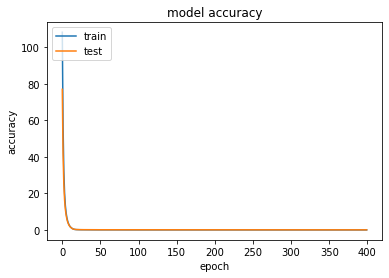

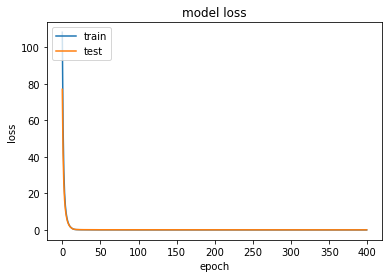

In [24]:
# summarize history for accuracy
plt.plot(history.history['mean_squared_logarithmic_error'])
plt.plot(history.history['val_mean_squared_logarithmic_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
"""df_test = pd.read_csv('test.csv')
cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']
id_col = df_test['Id'].values.tolist()
df_test['GrLivArea'] = np.log1p(df_test['GrLivArea'])
df_test = pd.get_dummies(df_test)
df_test = df_test.fillna(df_test.mean())
X_test = df_test[cols].values
# Always standard scale the data before using NN
scale = StandardScaler()
X_test = scale.fit_transform(X_test)"""

"df_test = pd.read_csv('test.csv')\ncols = ['OverallQual', 'GrLivArea', 'GarageCars', 'FullBath', 'YearBuilt']\nid_col = df_test['Id'].values.tolist()\ndf_test['GrLivArea'] = np.log1p(df_test['GrLivArea'])\ndf_test = pd.get_dummies(df_test)\ndf_test = df_test.fillna(df_test.mean())\nX_test = df_test[cols].values\n# Always standard scale the data before using NN\nscale = StandardScaler()\nX_test = scale.fit_transform(X_test)"

In [13]:
df_test = df_prediction_test_processed
X_test = df_test.values
# Always standard scale the data before using NN
scale = StandardScaler()
X_test = scale.fit_transform(X_test)

In [14]:
prediction = model.predict(X_test)
prediction

array([[ 92122.78],
       [434511.4 ],
       [182048.55],
       ...,
       [186264.69],
       [ 72234.94],
       [255255.02]], dtype=float32)

In [15]:
id_col_df = pd.read_csv('test.csv')
id_col = id_col_df['Id'].values.tolist()
submission = pd.DataFrame()
submission['Id'] = id_col
submission['SalePrice'] = prediction

In [16]:
submission.to_csv('submission.csv', index=False)